In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Klastrowanie hierarchiczne

In [2]:
np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df


,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


  * Aby obliczyć macierz odległości dla dla hierarchicznego algorytmu grupowania, użyjemy funkcji 
    ```python
    spatial.distance.pdist
    ```
    z modułu SciPy. Ta funkcja zwraca skondensowaną listę odległości.



In [6]:
from scipy.spatial.distance import pdist, squareform

pdist(df, metric='euclidean')

array([4.973534  , 5.51665266, 5.89988504, 3.83539555, 4.34707339,
       5.10431109, 6.69823298, 7.24426159, 8.31659367, 4.382864  ])

  * Macierz odległości zwróconą przez **pdist** użyjemy jako wejście do funkcji 
  
  ```python
  squareform
  ```
  w celu utworzenia symetrycznej macierzy odległości:

In [7]:
squareform(pdist(df, metric='euclidean'))

array([[0.        , 4.973534  , 5.51665266, 5.89988504, 3.83539555],
       [4.973534  , 0.        , 4.34707339, 5.10431109, 6.69823298],
       [5.51665266, 4.34707339, 0.        , 7.24426159, 8.31659367],
       [5.89988504, 5.10431109, 7.24426159, 0.        , 4.382864  ],
       [3.83539555, 6.69823298, 8.31659367, 4.382864  , 0.        ]])

In [8]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(
                pdist(df, metric='euclidean')),
                columns=labels,
                index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


Następnie zastosujemy algorytm **complete linkage agglomeration** za pomocą funkcji 
```python
cluster.hierarchy.linkage
```
która zwraca macierz połączeń (**linkage matrix**).

In [9]:
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')

Mżemy to również zrobic w następujący sposób:

In [10]:
row_clusters = linkage(df.values, method='complete', metric='euclidean')

In [11]:
row_clusters

array([[0.        , 4.        , 3.83539555, 2.        ],
       [1.        , 2.        , 4.34707339, 2.        ],
       [3.        , 5.        , 5.89988504, 3.        ],
       [6.        , 7.        , 8.31659367, 5.        ]])

Aby przyjrzeć się bliżej wynikom grupowania, możemy przekształcić je do DataFrame.

In [12]:
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


Zobaczmy jeszcze co zwraca funkcja linkage. Jest to tablica 2d gdzie w kolejnych wierszach mamy informacje o kolejnych scaleniach. Z[i] mówi które klastry zostały scalone w i-tej iteracji (format [idx1, idx2, dist, sample_count]).

Zauważmy, że mamy 5 punktów a numery klastrów przekraczają tę liczbę. Jeśli dwa punkty zostały scalone w klaster to nadawany jest mu nowy numer.

Ostatnia kolumna zwraca liczbę elementów w każdym klastrze

### Po obliczeniu macierzy powiązań możemy zwizualizować wyniki w postaci dendrogramu:

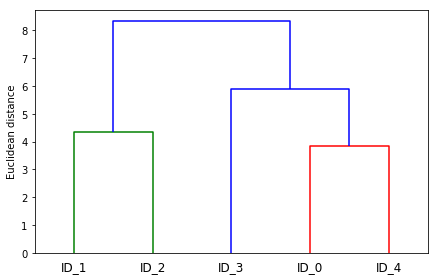

In [15]:
from scipy.cluster.hierarchy import dendrogram

# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

In [16]:
row_dendr['leaves']

[1, 2, 3, 0, 4]

Dla dużych dancyh dendrogram jest często niewyraźny (bardzo dużo liści). Możemy zawęzić go do kilku ostatnich scaleń:

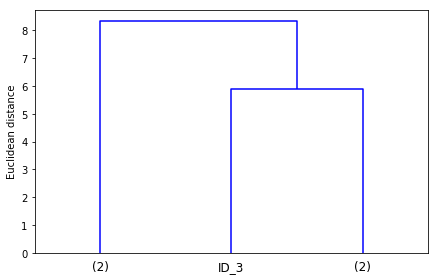

In [17]:
from scipy.cluster.hierarchy import dendrogram


row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       truncate_mode='lastp',  # show only the last p merged clusters
                       p=3,  # show only the last p merged clusters
                       show_leaf_counts=True
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

# Heat map

W praktycznych aplikacjach dendrogramy są często używane w połączeniu z mapą ciepła co pozwala reprezentować poszczególne wartości w macierzy próbek za pomocą kolorów.



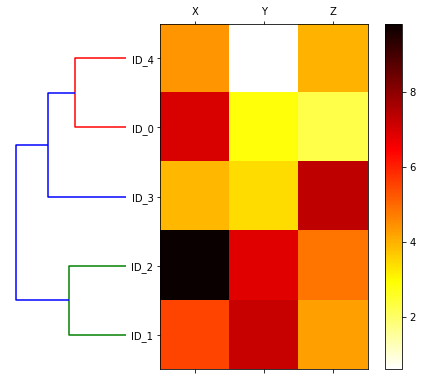

In [18]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

### Morzemy również wyliczyć przydział do klastrów 

Parametr criterion mówi jakie kryterium odcięcia przyjmujemy. Klastrowanie możemy obciąć albo na odległości odcięcia (klastry są przynajmniej w takiej odległości), albo na zadanej ilości

In [19]:
#row_clusters
from scipy.cluster.hierarchy import fcluster

part1 = fcluster(row_clusters, 2, criterion = 'maxclust')
part2 = fcluster(row_clusters, 3, criterion = 'maxclust')

print(part1)
print(part2)

[2 1 1 2 2]
[2 1 1 3 2]


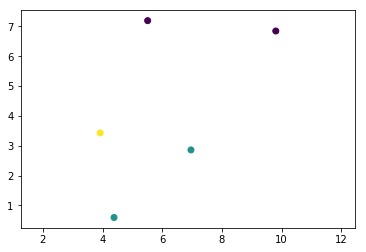

In [20]:
plt.scatter(X[:, 0], X[:, 1], c = part2)
plt.axis("equal")
plt.show()

In [21]:
#row_clusters
from scipy.cluster.hierarchy import fcluster

part1 = fcluster(row_clusters, 2, criterion = 'distance')
part2 = fcluster(row_clusters, 5, criterion = 'distance')

print(part1)
print(part2)

[3 1 2 5 4]
[2 1 1 3 2]


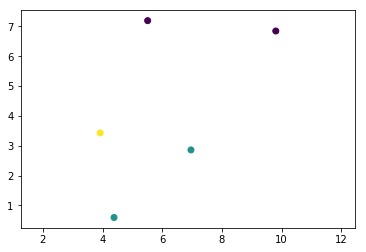

In [22]:
plt.scatter(X[:, 0], X[:, 1], c = part2)
plt.axis("equal")
plt.show()

Jeżeli wiemy ile chcemy klastrów (hierarchia nas nie interesuje) to możemy zawołać metodę z sklearn

In [23]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [1 0 0 2 1]


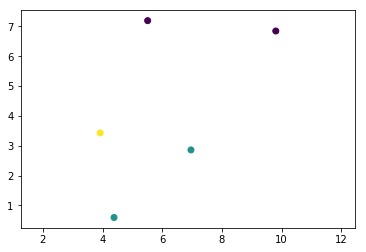

In [24]:
plt.scatter(X[:, 0], X[:, 1], c = labels)
plt.axis("equal")
plt.show()